# Script to train an AutoEncoder for the CIFAR-10 dataset. 
-------------------------------------------------------------------------------------------------------------------
### Technology used: Tensorflow-core 

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
from six.moves import cPickle as pickle # for reading the data
import matplotlib.pyplot as plt # for visualization
import numpy as np
from sklearn.preprocessing import OneHotEncoder # for encoding the labels in one hot form

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

Data
LICENSE
Models
README.md
requirements.txt
Scripts



In [4]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../Data/cifar-10-batches-py" # the data path
train_meta = os.path.join(data_path, "batches.meta")
base_model_path = '../Models'

# constant values:
size = 32 # the images of size 32 x 32
channels = 3 # RGB channels
highest_pixel_value = 255.0 # 8 bits for every channel. So, max value is 255
no_of_epochs = 100 # No. of epochs to run
no_of_batches = 5 # There are 5 batches in the dataset
checkpoint_factor = 5 # save the model after every 5 steps (epochs)

In [5]:
# check the contents inside the data folder
exec_command(['ls', data_path])

batches.meta
data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
readme.html
test_batch



In [6]:
# function to unPickle a file: 
def unpickle(file):
    '''
        This function takes the file path and unPickles the file acquired from it
        @Param file: the string path of the file
        @return: The dict object unPickled from the file
    '''
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

### Let's check the contents of the batches.meta file

In [7]:
meta_data = unpickle(train_meta)

# check it's contents
meta_data

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

### Let's read and display some of the images from the dataset along with their labels

In [8]:
train_batch_preliminary = unpickle(os.path.join(data_path, "data_batch_3"))

# check it's contents
train_batch_preliminary.keys()

['data', 'labels', 'batch_label', 'filenames']

In [9]:
# Extract the first 3 images from the dataset
preliminary_data = train_batch_preliminary['data'].reshape((len(train_batch_preliminary['data']), 32, 32, 3), 
                                                           order='F')
preliminary_labels = train_batch_preliminary['labels']

# view some of the data:
preliminary_data[33, :10, :10, 2] #(10 x 10) data of blue channel of 33rd image

array([[178, 191, 193, 197, 202, 206, 207, 209, 214, 219],
       [140, 151, 155, 160, 166, 172, 173, 171, 176, 180],
       [ 84,  94, 119, 151, 146, 127, 125, 135, 139, 139],
       [ 16,  18,  85, 200, 207, 133,  71,  59,  72,  79],
       [  9,   3,  51, 183, 238, 219, 177,  94,  30,  16],
       [ 31,  25,  38, 148, 240, 249, 255, 235, 139,  39],
       [ 69,  65,  62, 115, 215, 250, 248, 253, 245, 201],
       [ 92,  89,  81,  89, 173, 240, 249, 253, 253, 255],
       [ 93,  90,  84,  85, 139, 217, 241, 246, 251, 252],
       [ 75,  74,  71,  87, 154, 208, 229, 239, 245, 250]], dtype=uint8)

In [10]:
# check a few values of the labels of the dataset
preliminary_labels[:10] 

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2]

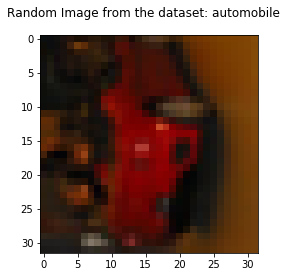

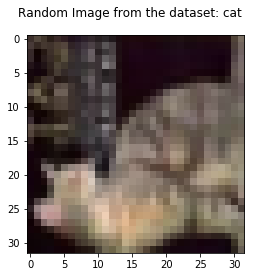

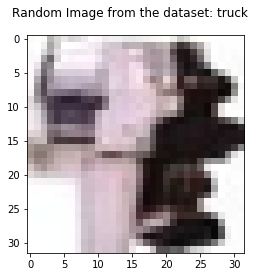

In [11]:
for _ in range(3):
    random_index = np.random.randint(preliminary_data.shape[0])
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
    plt.imshow(preliminary_data[random_index], interpolation='none')

### The images look blurred out because they are very low resolution images (32 x 32) pixels only.

## It can be seen that the images in the original dataset are skewed. So, we will have to rotate them by 90 degrees clockwise

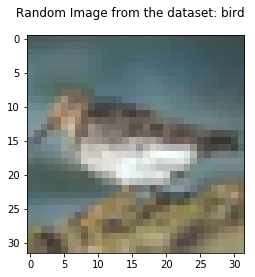

In [12]:
# let's try using the numpy.rot90 method for this:
random_index = np.random.randint(preliminary_data.shape[0])
    
plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
plt.imshow(np.rot90(preliminary_data[random_index], axes=(1, 0)), interpolation='none'); # suppress the unnecessary
# output

This works. So, now we can create a function to put all this together. This function would take the batch pickle file and create the data suitable for feeding it off to a convolutional neural network.

In [13]:
# The batch generator function:
def generateBatch(batchFile):
    '''
        The function to generate a batch of data suitable for performing the convNet operations on it
        @param batchFile -> the path of the input batchfile
        @return batch: (data, labels) -> the processed data.
    '''
    # unpickle the batch file:
    data_dict = unpickle(batchFile)
    
    # extract the data and labels from this dictionary
    unprocessed_data = data_dict['data']
    integer_labels = np.array(data_dict['labels']) # labels in integer form
    
    # reshape and rotate the data
    data = unprocessed_data.reshape((len(unprocessed_data), size, size, channels), order='F')
    processed_data = np.array(map(lambda x: np.rot90(x, axes=(1, 0)), data))
    
    # encode the labels in one-hot encoded form
    # we use the sklearn.preprocessing package for doing this
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = np.array(encoder.fit_transform(integer_labels.reshape(len(integer_labels), 1))).astype(np.int)
    
    # return the processed data and the encoded_labels:
    return (processed_data, encoded_labels)

### Time to test this function

In [14]:
# load the batch no. 1 and check if it works correctly.
batch_data, batch_labels = generateBatch(os.path.join(data_path, "data_batch_1"))
print (batch_data.shape, batch_labels.shape)

# batch_data[0, :12, :12, 2]

((10000, 32, 32, 3), (10000, 10))


Alright! So, the data extraction module is setup. Let's move on to the actual model building and training.

# The computation graph (tensorflow graph and not the weights) for this model is inside the computation_graph package. It can be imported from there

In [15]:
# import the graph from the Graph1 module 
import computation_graph.Graph1 

computation_graph = computation_graph.Graph1.graph

# obtain a handle on the encoded_representation tensor of the dataflow computation graph
encoded_representation = computation_graph.get_tensor_by_name("encoded_representation:0")
encoded_representation.shape # The output shape of the encoded representation. It is 32 x 2 x 2 i.e 128 
# Thus the latent representation is 128 dimensional

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(32)])

In [16]:
model_path = os.path.join(base_model_path, "Model1")

## Now, let's write the session code to run this computation graph and perform the training

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session(graph=computation_graph) as sess:
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
         # load the weights from the model1
        saver = tf.train.Saver(max_to_keep=2)

        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # create a new saver
        saver = tf.train.Saver(max_to_keep=2)
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range(50, no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            
            # retrieve the operations from the graph to be evaluated
            loss = sess.graph.get_tensor_by_name("loss:0")
            train_op = sess.graph.get_operation_by_name("train_op")
            inputs = sess.graph.get_tensor_by_name("inputs:0")
            
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = 2000 # we look at only 500 images at a time since the machine is small
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(len(batch_images) / min_batch_size):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, end), cost))
            
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, "model1"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

# Let's visualize the representation of a random image and it's reconstructed form

INFO:tensorflow:Restoring parameters from ../Models/Model1/model1-100
[[ 15  14  21  31  40  30  15  15  19  18   9  12]
 [ 10  10  14  20  28  27  15  11  17  16   9   9]
 [  8   8  10  13  25  24  19  19   9  10   9  11]
 [  9   8   9  11  15  15  22  35  19   9   8  10]
 [  8   8   9  12  13  12  14  28  18   6   8   9]
 [ 10  10   9  12  20  15  12  23  13   8  10   7]
 [ 10   9  10  13  23  24  13  25  16  16  19  23]
 [  8   8   9  12  17  27  17  28  17  63 133 168]
 [  8   8   7   9  13  27  41  72 102 178 215 220]
 [ 10   9   9  55  96 115 152 185 197 198 188 183]
 [ 14  10  35 115 132 150 176 178 170 170 167 161]
 [ 10   8  78 133 121 122 134 147 148 149 155 155]]
[[  1.83977146e+01   1.87713108e+01   1.75687695e+01   1.55326166e+01
    1.53827381e+01   1.50672102e+01   1.80636883e+01   1.54245415e+01
    1.02957716e+01   5.47046757e+00   1.65202868e+00   1.88587201e+00]
 [  1.84403515e+01   2.03542652e+01   1.70898724e+01   2.02607212e+01
    1.66576462e+01   1.63335285e+01 

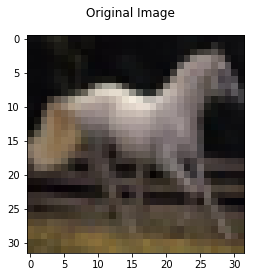

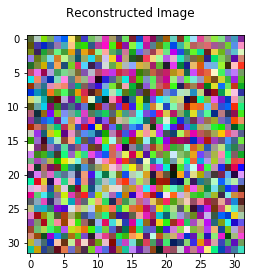

In [17]:
with tf.Session(graph = computation_graph) as sess:
    # load the weights from the model1
    saver = tf.train.Saver()
    
    # instead of global variable initializer, restore the graph:
    saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    prediction = sess.graph.get_tensor_by_name("prediction:0")
    inputs = sess.graph.get_tensor_by_name("inputs:0")
    
    random_image = batch_data[np.random.randint(len(batch_data))]
    reconstructed_image = sess.run(prediction, feed_dict={inputs: np.array([random_image])})[0]
    
    print random_image[:12, :12, 0]
    print reconstructed_image[:12, :12, 0]
    
    # plot the two images with their titles:
    plt.figure().suptitle("Original Image")
    plt.imshow(random_image, interpolation='none')
    
    print reconstructed_image.shape
    
    plt.figure().suptitle("Reconstructed Image")
    plt.imshow(reconstructed_image, interpolation='none')

# Use the 2nd model that has pooling layers to check the results:

In [18]:
# import the graph from the Graph1 module 
import computation_graph.Graph2

computation_graph = computation_graph.Graph2.graph

# obtain a handle on the encoded_representation tensor of the dataflow computation graph
encoded_representation = computation_graph.get_tensor_by_name("encoded_representation:0")
print encoded_representation.shape # The output shape of the encoded representation. It is 32 x 2 x 2 i.e 128 
# Thus the latent representation is 128 dimensional

# The prediction is again a good shaped tensor of dimensions 32 x 32 x 3
prediction = computation_graph.get_tensor_by_name("prediction:0")
prediction.shape # This is same as the original image dimensions

(?, 2, 2, 32)


TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)])

In [19]:
new_model_path = os.path.join(base_model_path, "Model2")

In [20]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session(graph=computation_graph) as sess:
    
    if(os.path.isfile(os.path.join(new_model_path, "checkpoint"))):
         # load the weights from the model2
        saver = tf.train.Saver(max_to_keep=2)

        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(new_model_path))
    
    else:
        # create a new saver
        saver = tf.train.Saver(max_to_keep=2)
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range(no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            
            # retrieve the operations from the graph to be evaluated
            loss = sess.graph.get_tensor_by_name("loss:0")
            train_op = sess.graph.get_operation_by_name("train_op")
            inputs = sess.graph.get_tensor_by_name("inputs:0")
            
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = 2000 # we look at only 500 images at a time since the machine is small
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(len(batch_images) / min_batch_size):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, end), cost))
            
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # save the model trained so far:
            saver.save(sess, os.path.join(new_model_path, "model2"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

epoch: 1
current_batch: 1
range:(0, 2000) loss= 120.929084778
range:(2000, 4000) loss= 119.710044861
range:(4000, 6000) loss= 119.268371582
range:(6000, 8000) loss= 116.37550354
range:(8000, 10000) loss= 113.578697205


current_batch: 2
range:(0, 2000) loss= 102.825080872
range:(2000, 4000) loss= 87.4618759155
range:(4000, 6000) loss= 72.5240936279
range:(6000, 8000) loss= 81.4190444946
range:(8000, 10000) loss= 79.6826629639


current_batch: 3
range:(0, 2000) loss= 67.7745132446
range:(2000, 4000) loss= 60.9294128418
range:(4000, 6000) loss= 61.6961555481
range:(6000, 8000) loss= 62.401763916
range:(8000, 10000) loss= 61.2867927551


current_batch: 4
range:(0, 2000) loss= 57.4386367798
range:(2000, 4000) loss= 52.9662666321
range:(4000, 6000) loss= 54.1124572754
range:(6000, 8000) loss= 56.6125831604
range:(8000, 10000) loss= 53.4495887756


current_batch: 5
range:(0, 2000) loss= 50.5567092896
range:(2000, 4000) loss= 49.7531814575
range:(4000, 6000) loss= 51.1296424866
range:(6000, 8

current_batch: 5
range:(0, 2000) loss= 29.8489055634
range:(2000, 4000) loss= 29.7640628815
range:(4000, 6000) loss= 29.5262088776
range:(6000, 8000) loss= 29.4543571472
range:(8000, 10000) loss= 29.4384269714


epoch: 6
current_batch: 1
range:(0, 2000) loss= 29.7215251923
range:(2000, 4000) loss= 29.5651321411
range:(4000, 6000) loss= 29.1478481293
range:(6000, 8000) loss= 29.2611293793
range:(8000, 10000) loss= 29.39245224


current_batch: 2
range:(0, 2000) loss= 29.2324314117
range:(2000, 4000) loss= 29.3602924347
range:(4000, 6000) loss= 29.1149864197
range:(6000, 8000) loss= 29.2489719391
range:(8000, 10000) loss= 29.077627182


current_batch: 3
range:(0, 2000) loss= 28.6681976318
range:(2000, 4000) loss= 28.9062595367
range:(4000, 6000) loss= 29.0086250305
range:(6000, 8000) loss= 28.6974430084
range:(8000, 10000) loss= 29.1331539154


current_batch: 4
range:(0, 2000) loss= 28.9500370026
range:(2000, 4000) loss= 28.3531303406
range:(4000, 6000) loss= 28.5830211639
range:(6000, 80

current_batch: 4
range:(0, 2000) loss= 25.6610469818
range:(2000, 4000) loss= 25.1605415344
range:(4000, 6000) loss= 25.396697998
range:(6000, 8000) loss= 25.5109157562
range:(8000, 10000) loss= 24.9655017853


current_batch: 5
range:(0, 2000) loss= 25.2908382416
range:(2000, 4000) loss= 25.3447551727
range:(4000, 6000) loss= 25.0316047668
range:(6000, 8000) loss= 25.0598907471
range:(8000, 10000) loss= 25.0657711029


epoch: 11
current_batch: 1
range:(0, 2000) loss= 25.4389343262
range:(2000, 4000) loss= 25.3038845062
range:(4000, 6000) loss= 24.9219608307
range:(6000, 8000) loss= 25.3237819672
range:(8000, 10000) loss= 25.7062835693


current_batch: 2
range:(0, 2000) loss= 25.8234996796
range:(2000, 4000) loss= 26.0316467285
range:(4000, 6000) loss= 25.2204914093
range:(6000, 8000) loss= 25.0031871796
range:(8000, 10000) loss= 25.2061634064


current_batch: 3
range:(0, 2000) loss= 25.1890678406
range:(2000, 4000) loss= 25.6501712799
range:(4000, 6000) loss= 25.1180477142
range:(6000,

KeyboardInterrupt: 